# Synthetic Data Generation using SMOTE 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from random import choice
from sklearn.neighbors import NearestNeighbors
%matplotlib inline


In [3]:
df_full = pd.read_csv (r'./adult.csv')
df_full.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


The dataset contains missing values denoted by __'?'__. So for the sake of simplicity, I have dropped the columns containing them

In [4]:
# check for '?' values in each feature column

for col in df_full.columns:
    missing_val = df_full.loc[df_full[col]=='?',col].size
    if missing_val:
        print(col,'---MISSING VALUES---: ',missing_val )

workclass ---MISSING VALUES---:  1836
occupation ---MISSING VALUES---:  1843
native.country ---MISSING VALUES---:  583


/home/rahul/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [5]:
# drop the columns containing missing for simplicity. (Rows containing the missing values can also be dropped)

df_full = df_full.drop(columns=['workclass','occupation', 'native.country'])

Rearranging the columns containing numerical features followed by catergorical ones

In [6]:
num_cols = list(set(df_full.describe().columns))

categorical_cols = list(set(df_full.columns) - set(df_full.describe().columns))

df = df_full[num_cols + categorical_cols].copy()

df.head()

,capital.loss,fnlwgt,age,capital.gain,education.num,hours.per.week,sex,relationship,income,race,marital.status,education
0,4356,77053,90,0,9,40,Female,Not-in-family,<=50K,White,Widowed,HS-grad
1,4356,132870,82,0,9,18,Female,Not-in-family,<=50K,White,Widowed,HS-grad
2,4356,186061,66,0,10,40,Female,Unmarried,<=50K,Black,Widowed,Some-college
3,3900,140359,54,0,4,40,Female,Unmarried,<=50K,White,Divorced,7th-8th
4,3900,264663,41,0,10,40,Female,Own-child,<=50K,White,Separated,Some-college


The categorical features are __one-hot encoded__ using OneHotEncoder from sklearn

In [7]:
df_array = df.to_numpy()

enc = OneHotEncoder(handle_unknown='ignore')     # one hot encoding the categorical features
one_hot_categorical = enc.fit_transform(df_array[:,len(num_cols):]).toarray()

The __SMOTE-NC__ technique's algorithm is implemented in following steps as mentioned in the paper:

## STEP-1 :  Median computation 
- The __median of standard deviations__ of all continuous features are computed. 
- If the nominal features differ between a sample and its potential nearest neighbors, then this median is included in the Euclidean distance computation. 
- Here the median of the standard deviations of continuous features is used to __penalize__ the difference of nominal features by an amount that is related to the typical difference in continuous feature values.

In [8]:
numerical_features = df_array[:,:len(num_cols)].astype(np.float64)
median_std = np.median(np.sqrt(numerical_features.var(axis= 0)))  # median of standard deviations
one_hot_categorical[one_hot_categorical>0] = median_std / 2  # The 1's in one-hot encoding are replaced  by median_std/2 
                                                            # to include the median directly in euclidean distance computation.

In [9]:
df_one_hot = np.append(numerical_features,one_hot_categorical,axis=1) # data frame containing numerical and 
                                                                      # one-hot encoded categorical features

After creating a data frame containing continuous and one-hot encoded features, we proceed to next step

## STEP-2 :  Nearest neighbor computation
- The Euclidean distance between the feature vector and k-nearest neighbors are to be calculated.
- For this purpose, We can use __NearestNeighbors__ from sklearn.
- For every differing nominal feature between the considered feature vector and its potential nearest-neighbor, median of the standard deviations should be considered and they are already included for the Euclidean distance computation from previous step.

#### NOTE:
The number of nearest neighours are set to __5__ and is a hyperparameter to  be adjusted.

In [10]:
neighbours = NearestNeighbors(n_neighbors = 5)   # setting the nearest k-neighbours (hyperparameter)
neighbours.fit(df_one_hot)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

## STEP-3 :  Populate the synthetic samples
- The __continuous features__ of the new synthetic samples are created using __SMOTE__ technique. 
- This technique works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

- The __nominal features__ are given the value occuring in the __majority__ of the k-nearest neighbors.

In [11]:
%%time
syn_data = np.zeros_like(df_array)
for i in range(len(df_array)):
    nn = neighbours.kneighbors(df_one_hot[i].reshape(1, -1), return_distance=False)
    a = enc.inverse_transform(df_one_hot[nn[0]][:, len(num_cols):] / (median_std / 2).reshape(-1, 1)) # obtaining categorical values

    categorical_recon = [max(q, key=q.count) for q in zip(*a)]  # majority of k nearest neighbours

    nn_index = choice(nn[0]) # choose one of the k-nearest neighbours
    while nn_index == i:     # Since nn also includes df_one_hot[i] value, we don't want to select it
        nn_index = choice(nn[0])

    difference = (df_one_hot[nn_index] - df_one_hot[i])[:len(num_cols)]
    gap = np.random.random()
    numerical_recon = (df_one_hot[i][:len(num_cols)] + (gap * difference)).astype('int64')

    syn_data[i] = np.append(numerical_recon, categorical_recon)

CPU times: user 16.1 s, sys: 608 ms, total: 16.7 s
Wall time: 16.7 s


The __reconstructed__ synthetic data is now stored in a dataframe to compare with the original data

In [12]:
# Obtain the synthetic data and store in data frame

df_recon = pd.DataFrame(data=syn_data, columns=df.columns).astype({'hours.per.week': 'int64',
                                                                         'age': 'int64',
                                                                         'fnlwgt': 'int64',
                                                                         'capital.gain': 'int64',
                                                                         'capital.loss': 'int64',
                                                                         'education.num': 'int64',
                                                                         })

## Compare original and reconstructed data

In [13]:
# For original dataset

df.head()

,capital.loss,fnlwgt,age,capital.gain,education.num,hours.per.week,sex,relationship,income,race,marital.status,education
0,4356,77053,90,0,9,40,Female,Not-in-family,<=50K,White,Widowed,HS-grad
1,4356,132870,82,0,9,18,Female,Not-in-family,<=50K,White,Widowed,HS-grad
2,4356,186061,66,0,10,40,Female,Unmarried,<=50K,Black,Widowed,Some-college
3,3900,140359,54,0,4,40,Female,Unmarried,<=50K,White,Divorced,7th-8th
4,3900,264663,41,0,10,40,Female,Own-child,<=50K,White,Separated,Some-college


In [14]:
# For reconstructed data

df_recon.head()

,capital.loss,fnlwgt,age,capital.gain,education.num,hours.per.week,sex,relationship,income,race,marital.status,education
0,3168,77063,51,0,11,37,Female,Not-in-family,<=50K,White,Married-civ-spouse,HS-grad
1,3999,132964,74,0,9,22,Male,Husband,>50K,White,Married-civ-spouse,HS-grad
2,3497,186197,64,0,11,40,Male,Husband,>50K,White,Married-civ-spouse,Some-college
3,3577,140630,50,0,6,41,Male,Not-in-family,<=50K,White,Divorced,7th-8th
4,2909,264878,42,0,9,40,Male,Husband,>50K,White,Married-civ-spouse,Some-college


From the above data frame results we see that the synthetic data is __different__ from the original but has the __same__ distribution which can be seen from the bar and histogram plots shown below

In [15]:
def plot_figure(df):
    plt.figure(figsize=(20,40))

    for i in range(len(df.columns)):
        plt.subplot(6,2,i+1)
        if df[df.columns[i]].dtype == 'object': # categorical data
            df[df.columns[i]].value_counts().plot(kind='bar', legend=True, fontsize=14)
            plt.legend(fontsize=20)
        else:  # continuous data plotted in green
            df[df.columns[i]].plot(kind='hist',color='green', legend=True, fontsize=14)
            plt.legend(fontsize=20)


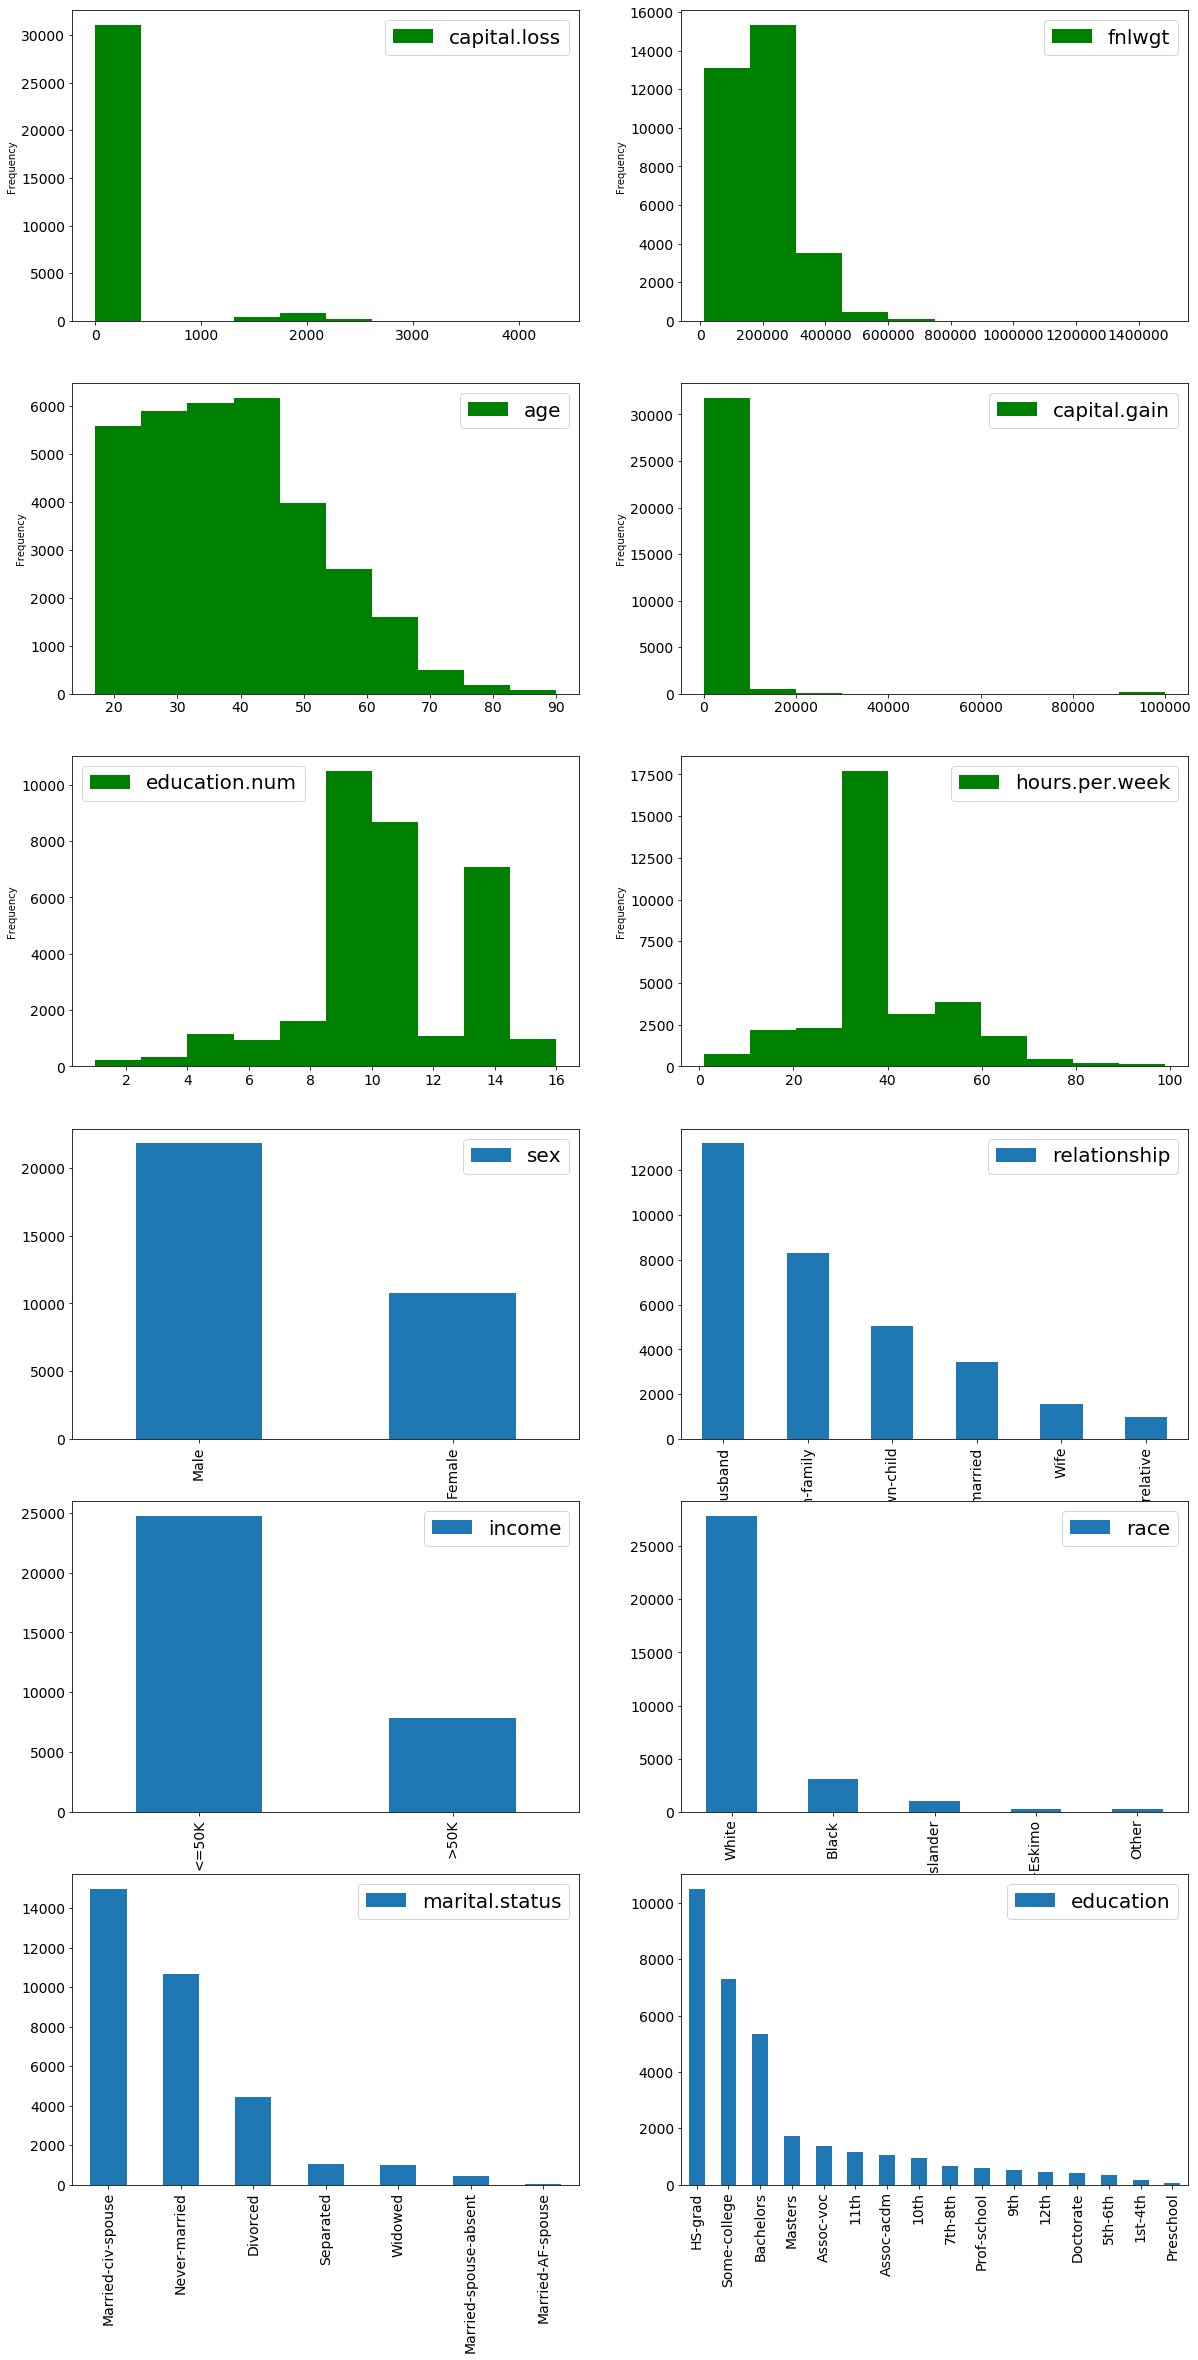

In [16]:
# For original dataset

plot_figure(df)

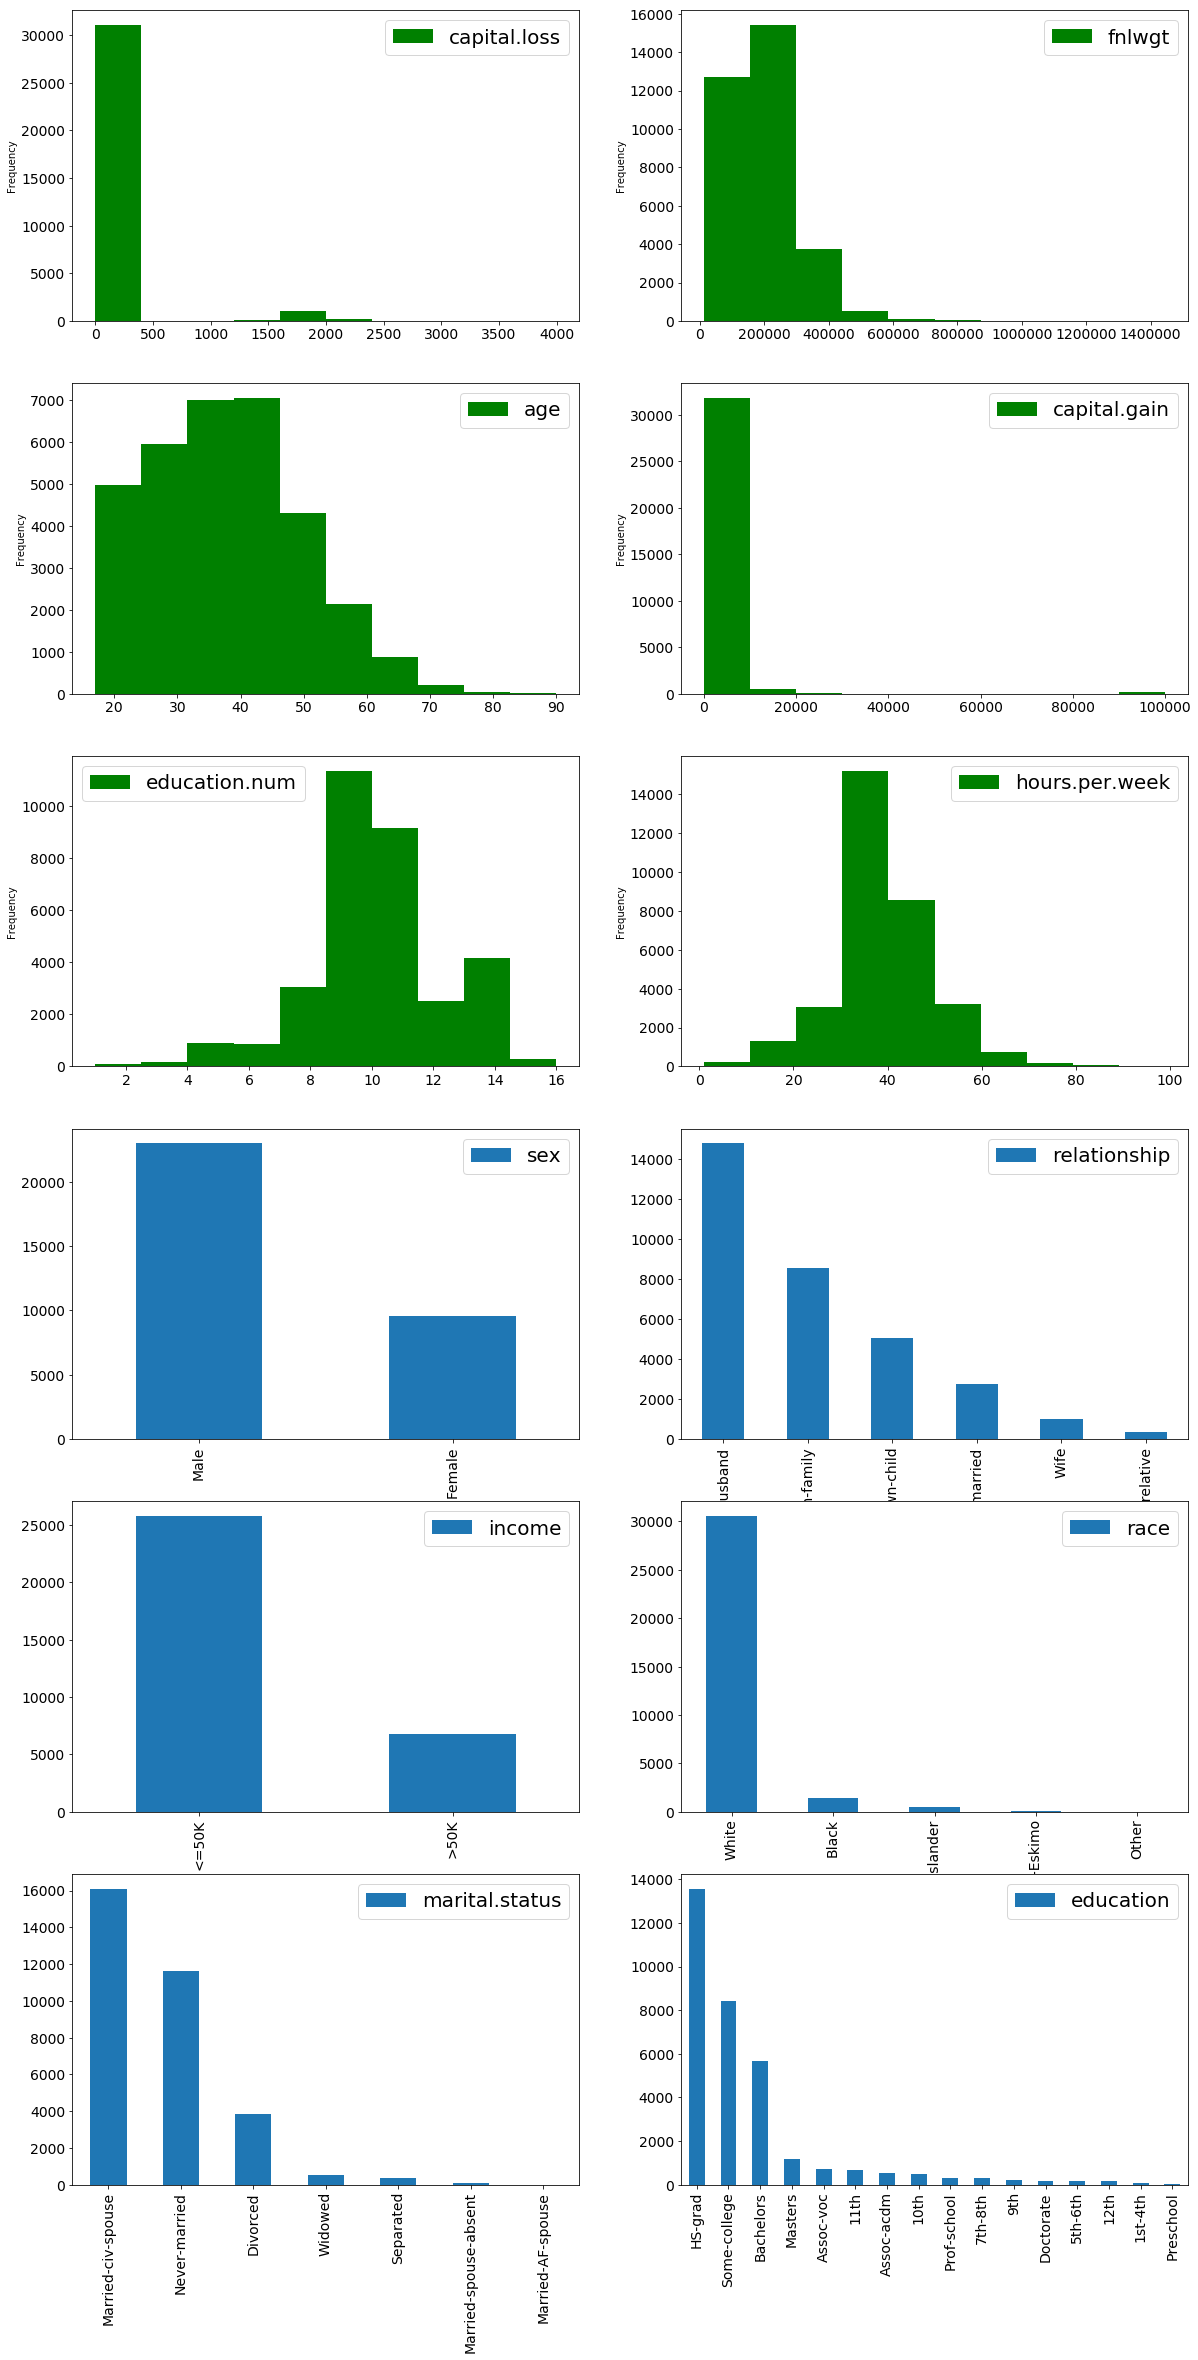

In [17]:
# For reconstructed data
plot_figure(df_recon)

## Correlation Matrix for Continous features

- We see that the distributions are almost similar for both continous and categorical variables. But correlation between the features is also __important__.
- To verify this, We plot the correlation matrix for continuous features.
- I observed that the results obtained for original and reconstructed synthetic data are __similar__ and they are shown below:

In [18]:
# For original dataset
df.corr()

,capital.loss,fnlwgt,age,capital.gain,education.num,hours.per.week
capital.loss,1.000000,-0.010252,0.057775,-0.031615,0.079923,0.054256
fnlwgt,-0.010252,1.000000,-0.076646,0.000432,-0.043195,-0.018768
age,0.057775,-0.076646,1.000000,0.077674,0.036527,0.068756
capital.gain,-0.031615,0.000432,0.077674,1.000000,0.122630,0.078409
education.num,0.079923,-0.043195,0.036527,0.122630,1.000000,0.148123
hours.per.week,0.054256,-0.018768,0.068756,0.078409,0.148123,1.000000


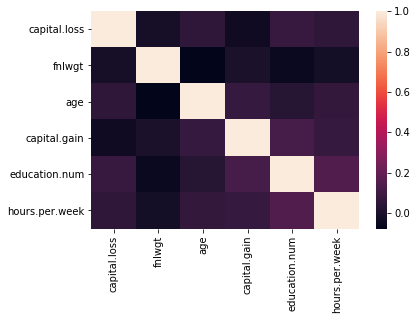

In [19]:
# For original dataset
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns)

In [20]:
# For reconstructed data
df_recon.corr()

,capital.loss,fnlwgt,age,capital.gain,education.num,hours.per.week
capital.loss,1.000000,-0.016736,0.063584,-0.031242,0.082604,0.064068
fnlwgt,-0.016736,1.000000,-0.087184,-0.002342,-0.061409,-0.032220
age,0.063584,-0.087184,1.000000,0.093595,0.054850,0.141601
capital.gain,-0.031242,-0.002342,0.093595,1.000000,0.138676,0.100025
education.num,0.082604,-0.061409,0.054850,0.138676,1.000000,0.161807
hours.per.week,0.064068,-0.032220,0.141601,0.100025,0.161807,1.000000


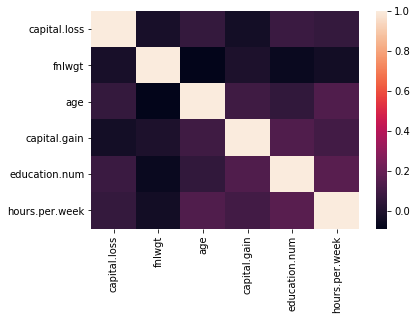

In [21]:
# For reconstructed data
sns.heatmap(df_recon.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns)

## Observations

- We can observe from the results that if the features are skewed especially the categorical features, we cannot obtain good synthesized results (for example: 'race' feature which was skewed). Futher investigation is required to deal with this issue.


## Future Steps

- Since the missing values columns are ignored, we can perform data imputation and then synthesize new samples. 

- Bayesian methods can also be used to create synthetic datasets<br>
__Link__ : https://faculty.washington.edu/billhowe/publications/pdfs/ping17datasynthesizer.pdf


